# **Spam Classifier**

In [1]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk # biblioteca de NLP
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter

ps = PorterStemmer()

nltk.download('punkt') # modelo para a tokenização

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BeatrizAlmeida\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Data Cleaning

In [2]:
data = pd.read_csv("data/spam.csv", encoding='latin1')
data.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data.shape

(5572, 5)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [6]:
data.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
data.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
data.head(5)

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
encoder = LabelEncoder()

data['target'] = encoder.fit_transform(data['target'])

In [9]:
data.head(5)

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
data.isnull().sum()

target    0
text      0
dtype: int64

In [11]:
data.duplicated().sum()

403

In [12]:
data = data.drop_duplicates(keep='first')

In [13]:
data.duplicated().sum()

0

In [14]:
data.shape

(5169, 2)

## 2. EDA

In [15]:
data['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

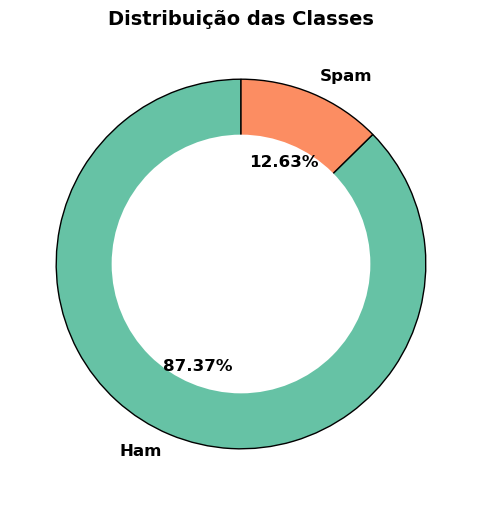

In [16]:
import matplotlib.pyplot as plt


counts = data['target'].value_counts()

colors = ['#66c2a5', '#fc8d62']

fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    counts, 
    labels=['Ham', 'Spam'], 
    autopct='%0.2f%%', 
    startangle=90, 
    colors=colors, 
    wedgeprops={'edgecolor': 'black'}, 
    textprops={'fontsize': 12, 'weight': 'bold'}
)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.title('Distribuição das Classes', fontsize=14, weight='bold')
plt.show()


In [17]:
data['num_chars'] = data['text'].apply(len)
data.head()

,target,text,num_chars
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [18]:
data['num_words'] = data['text'].apply(lambda x:len(nltk.word_tokenize(x))) # divisão do texto em tokens
data.head()

,target,text,num_chars,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [19]:
data['num_sentences'] = data['text'].apply(lambda x:len(nltk.sent_tokenize(x))) # divisão do texto em sentenças
data.head()

,target,text,num_chars,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [20]:
data[['num_chars', 'num_words', 'num_sentences']].describe()

,num_chars,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [21]:
data[data['target'] == 0][['num_chars', 'num_words', 'num_sentences']].describe()

,num_chars,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [22]:
data[data['target'] == 1][['num_chars', 'num_words', 'num_sentences']].describe()

,num_chars,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


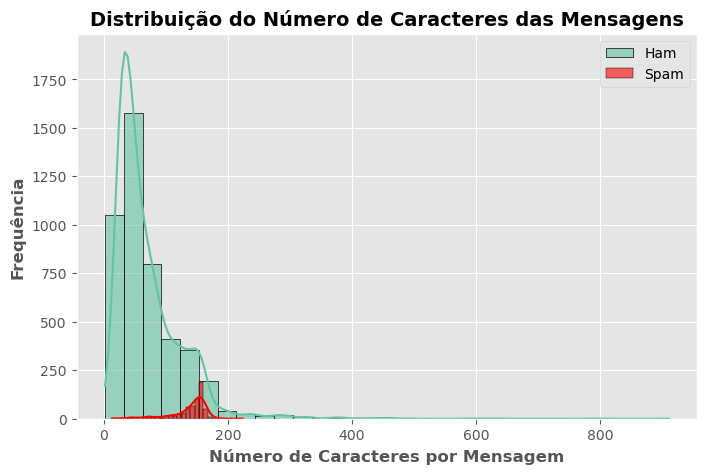

In [23]:
plt.style.use('ggplot')

plt.figure(figsize=(8, 5))

sns.histplot(
    data[data['target'] == 0]['num_chars'], 
    bins=30, 
    kde=True, 
    color='#66c2a5', 
    edgecolor='black', 
    alpha=0.6, 
    label='Ham'
)

sns.histplot(
    data[data['target'] == 1]['num_chars'], 
    bins=30, 
    kde=True, 
    color='red', 
    edgecolor='black', 
    alpha=0.6, 
    label='Spam'
)

plt.xlabel('Número de Caracteres por Mensagem', fontsize=12, weight='bold')
plt.ylabel('Frequência', fontsize=12, weight='bold')
plt.title('Distribuição do Número de Caracteres das Mensagens', fontsize=14, weight='bold')
plt.legend()

plt.show()

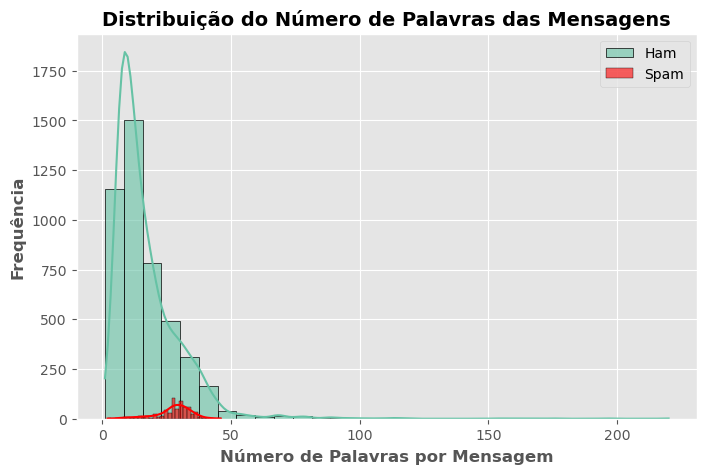

In [24]:
plt.style.use('ggplot')

plt.figure(figsize=(8, 5))

sns.histplot(
    data[data['target'] == 0]['num_words'], 
    bins=30, 
    kde=True, 
    color='#66c2a5', 
    edgecolor='black', 
    alpha=0.6, 
    label='Ham'
)

sns.histplot(
    data[data['target'] == 1]['num_words'], 
    bins=30, 
    kde=True, 
    color='red', 
    edgecolor='black', 
    alpha=0.6, 
    label='Spam'
)

plt.xlabel('Número de Palavras por Mensagem', fontsize=12, weight='bold')
plt.ylabel('Frequência', fontsize=12, weight='bold')
plt.title('Distribuição do Número de Palavras das Mensagens', fontsize=14, weight='bold')
plt.legend()

plt.show()

c:\Users\BeatrizAlmeida\anaconda3\envs\mnist\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


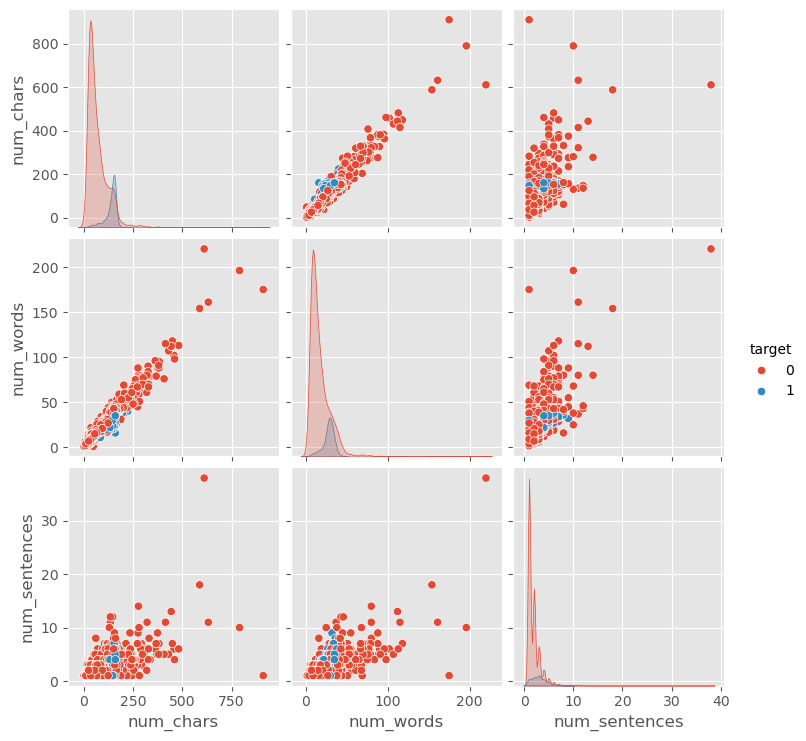

In [25]:
sns.pairplot(data, hue='target')

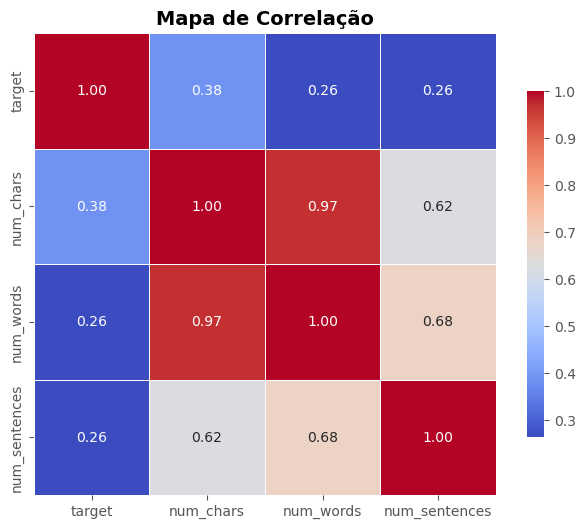

In [26]:
plt.figure(figsize=(8, 6))

sns.heatmap(
    data.corr(numeric_only=True), 
    annot=True,  # exibe os valores dentro das células
    fmt=".2f",  
    cmap="coolwarm",  
    linewidths=0.5,  
    square=True,  
    cbar_kws={'shrink': 0.75}  # ajusta a barra de cores para ficar proporcional
)

plt.title('Mapa de Correlação', fontsize=14, weight='bold')

plt.show()

## 3. Text Processing

- lower case
- tokenization
- removing special chars
- removing stop words and punctuation
- stemming

In [27]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum(): # deixar somente alfanumericos
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    
    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))
            
    return " ".join(y)

In [28]:
data['transformed_text'] = data['text'].apply(transform_text)
data.head()

,target,text,num_chars,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


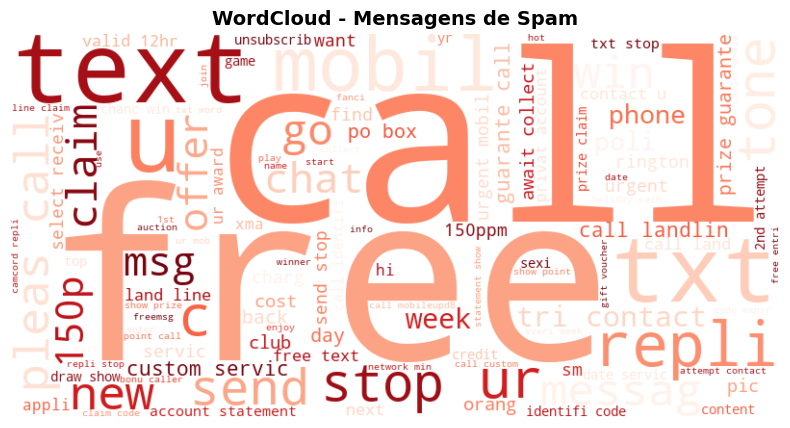

In [29]:
wc = WordCloud(
    width=800, height=400,  
    min_font_size=10,
    background_color='white',
    colormap="Reds",  
    contour_width=1.5,
    contour_color='red'  
)

spam_wc = wc.generate(data[data['target'] == 1]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(10, 5))  
plt.imshow(spam_wc, interpolation="bilinear")  
plt.axis("off")  
plt.title("WordCloud - Mensagens de Spam", fontsize=14, weight='bold')  

plt.show()


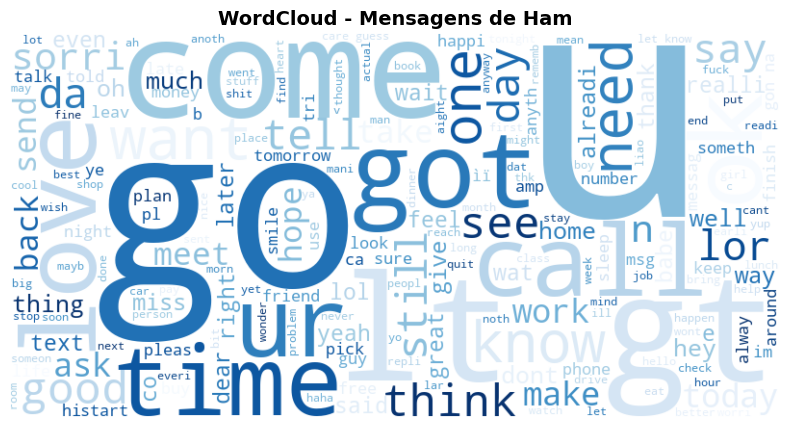

In [30]:
wc = WordCloud(
    width=800, height=400,  
    min_font_size=10,
    background_color='white',
    colormap="Blues",  
    contour_width=1.5,
    contour_color='blue'  
)

ham_wc = wc.generate(data[data['target'] == 0]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(10, 5))  
plt.imshow(ham_wc, interpolation="bilinear")  
plt.axis("off")  
plt.title("WordCloud - Mensagens de Ham", fontsize=14, weight='bold')  

plt.show()


In [31]:
spam_corpus = []

for msg in data[data['target']==1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

ham_corpus = []

for msg in data[data['target']==0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

len(spam_corpus), len(ham_corpus)

(9939, 35404)

C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_5844\2462188742.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


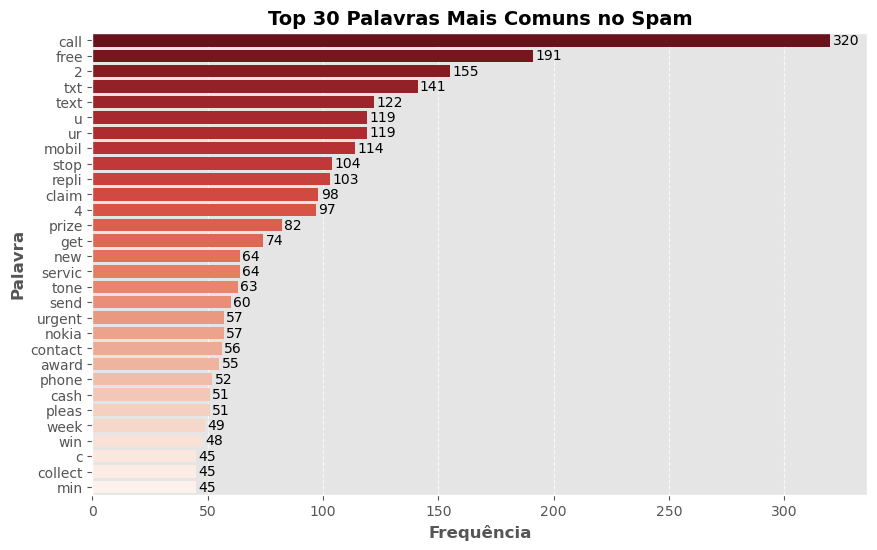

In [32]:
spam_words_df = pd.DataFrame(Counter(spam_corpus).most_common(30), columns=['Palavra', 'Frequência'])

plt.figure(figsize=(10, 6))

sns.barplot(
    y=spam_words_df['Palavra'], 
    x=spam_words_df['Frequência'], 
    palette="Reds_r"  # paleta de cores vermelha invertida
)

for index, value in enumerate(spam_words_df['Frequência']):
    plt.text(value + 1, index, str(value), fontsize=10, verticalalignment='center')

plt.xlabel("Frequência", fontsize=12, weight='bold')
plt.ylabel("Palavra", fontsize=12, weight='bold')
plt.title("Top 30 Palavras Mais Comuns no Spam", fontsize=14, weight='bold')

plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

C:\Users\BeatrizAlmeida\AppData\Local\Temp\ipykernel_5844\187016862.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


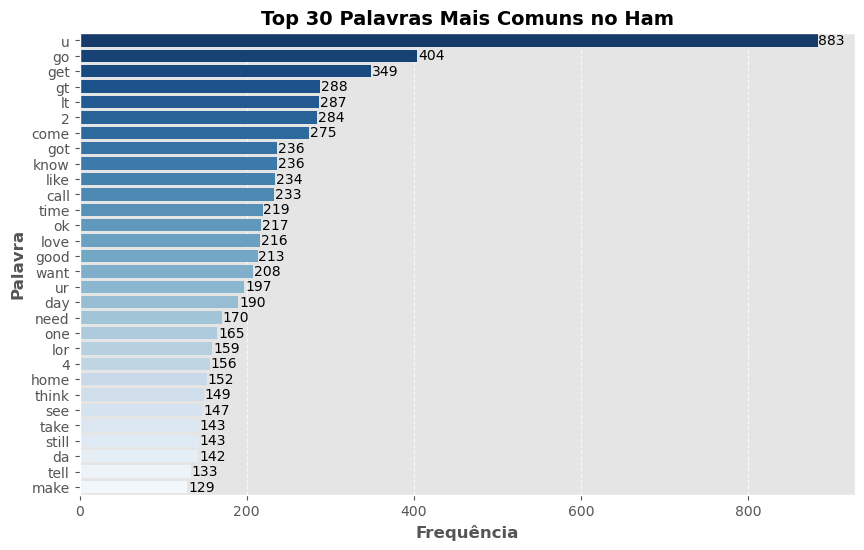

In [33]:
ham_words_df = pd.DataFrame(Counter(ham_corpus).most_common(30), columns=['Palavra', 'Frequência'])

plt.figure(figsize=(10, 6))

sns.barplot(
    y=ham_words_df['Palavra'], 
    x=ham_words_df['Frequência'], 
    palette="Blues_r"  # paleta de cores azul invertida
)

for index, value in enumerate(ham_words_df['Frequência']):
    plt.text(value + 1, index, str(value), fontsize=10, verticalalignment='center')

plt.xlabel("Frequência", fontsize=12, weight='bold')
plt.ylabel("Palavra", fontsize=12, weight='bold')
plt.title("Top 30 Palavras Mais Comuns no Ham", fontsize=14, weight='bold')

plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

## 4. Model Building

In [40]:
cv = CountVectorizer() # transforma textos em valores numéricos para o modelo funcionar
tfidf = TfidfVectorizer() # atribui pesos as palavras de acordo com sua relevancia

X1 = cv.fit_transform(data['transformed_text']).toarray()
X2 = tfidf.fit_transform(data['transformed_text']).toarray()

X1.shape # -> (numero_textos, palavras_unicas_vocab)

(5169, 6708)

In [35]:
y = data['target'].values
y

array([0, 0, 1, ..., 0, 0, 0])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=2)

In [37]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8800773694390716
[[792 104]
 [ 20 118]]
0.5315315315315315


In [38]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9642166344294004
[[871  25]
 [ 12 126]]
0.8344370860927153


In [39]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9700193423597679
[[893   3]
 [ 28 110]]
0.9734513274336283


---

### Teste TFid

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=2)

gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8762088974854932
[[793 103]
 [ 25 113]]
0.5231481481481481


In [43]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9593810444874274
[[896   0]
 [ 42  96]]
1.0


In [44]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9700193423597679
[[893   3]
 [ 28 110]]
0.9734513274336283


----

### Outros Modelos

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [48]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2)

In [ ]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [50]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    return accuracy,precision

In [51]:
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    
    current_accuracy, current_precision = train_classifier(clf, X_train, y_train, X_test, y_test)
    
    print("For ", name)
    print("Accuracy - ", current_accuracy)
    print("Precision - ", current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9729206963249516
Precision -  0.9741379310344828
For  KN
Accuracy -  0.9003868471953579
Precision -  1.0
For  NB
Accuracy -  0.9593810444874274
Precision -  1.0
For  DT
Accuracy -  0.9352030947775629
Precision -  0.8380952380952381
For  LR
Accuracy -  0.9516441005802708
Precision -  0.94
For  RF
Accuracy -  0.971953578336557
Precision -  1.0
For  AdaBoost
Accuracy -  0.9613152804642167
Precision -  0.9454545454545454
For  BgC
Accuracy -  0.9584139264990329
Precision -  0.8625954198473282
For  ETC
Accuracy -  0.9729206963249516
Precision -  0.9824561403508771
For  GBDT
Accuracy -  0.9526112185686654
Precision -  0.9238095238095239
For  xgb
Accuracy -  0.9729206963249516
Precision -  0.9435483870967742


In [52]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision', ascending=False)
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.900387,1.000000
2,NB,0.959381,1.000000
5,RF,0.971954,1.000000
8,ETC,0.972921,0.982456
0,SVC,0.972921,0.974138
6,AdaBoost,0.961315,0.945455
10,xgb,0.972921,0.943548
4,LR,0.951644,0.940000
9,GBDT,0.952611,0.923810
7,BgC,0.958414,0.862595


In [53]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1

,Algorithm,variable,value
0,KN,Accuracy,0.900387
1,NB,Accuracy,0.959381
2,RF,Accuracy,0.971954
3,ETC,Accuracy,0.972921
4,SVC,Accuracy,0.972921
5,AdaBoost,Accuracy,0.961315
6,xgb,Accuracy,0.972921
7,LR,Accuracy,0.951644
8,GBDT,Accuracy,0.952611
9,BgC,Accuracy,0.958414


c:\Users\BeatrizAlmeida\anaconda3\envs\mnist\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x500 with 0 Axes>

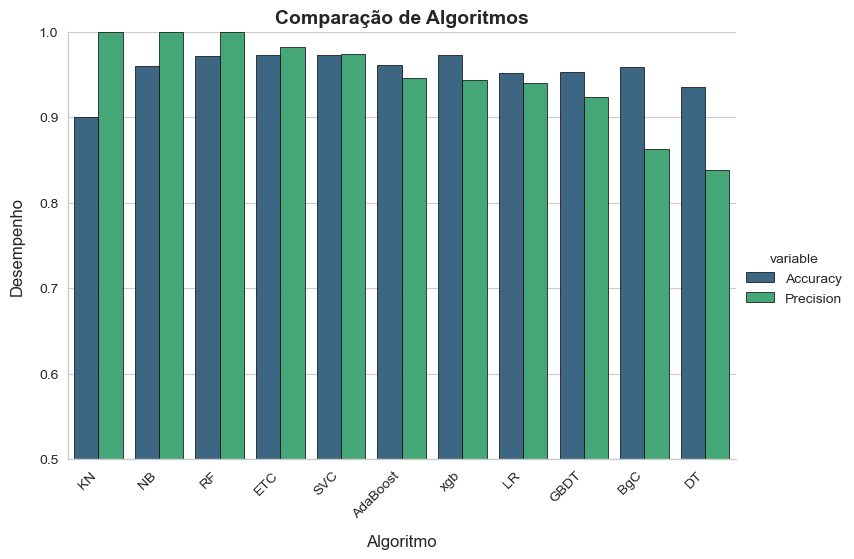

In [54]:
sns.set_style("whitegrid")  
plt.figure(figsize=(8, 5)) 

g = sns.catplot(
    x='Algorithm', 
    y='value', 
    hue='variable', 
    data=performance_df1, 
    kind='bar', 
    height=5, 
    aspect=1.5,  
    palette="viridis",  
    edgecolor="black"  
)

plt.ylim(0.5, 1.0)
plt.xticks(rotation=45, ha='right')  
plt.xlabel("Algoritmo", fontsize=12, labelpad=10)
plt.ylabel("Desempenho", fontsize=12, labelpad=10)
plt.title("Comparação de Algoritmos", fontsize=14, fontweight="bold")

plt.show()

## 5. Improvement

In [56]:
from sklearn.ensemble import VotingClassifier

svc = SVC(kernel='sigmoid', gamma=1.0, probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

# Voting Classifier para combinar varios modelos bons
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)], voting='soft')

voting.fit(X_train, y_train)

y_pred = voting.predict(X_test)

# avaliação do modelo
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))

Accuracy 0.9787234042553191
Precision 1.0


In [57]:
from sklearn.ensemble import StackingClassifier

# modelos base
estimators = [('svm', svc), ('nb', mnb), ('et', etc)]

# modelo final para aprender melhor forma de combinar os modelos
final_estimator = RandomForestClassifier()

# Stacking Classifier que aprende a combinar as previsões da melhor maneira
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))

Accuracy 0.9816247582205029
Precision 0.9612403100775194
